# Timing of separable filters

In [1]:
%matplotlib inline

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy import signal

First, let us load and display the input image

Image shape:  (256, 256)


(-0.5, 255.5, 255.5, -0.5)

/home/oskrede/anaconda3/envs/inf2310/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


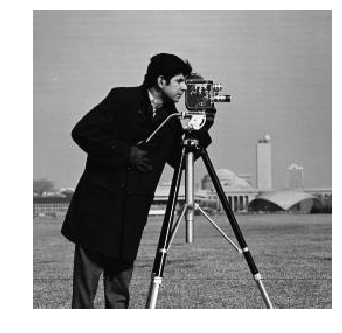

In [2]:
im = cv2.imread('assets/images/cameraman.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap='gray')
print('Image shape: ', im.shape)
plt.axis('off')

Now, let us implement a function that computes a 2D convolution *without* utilizing the separability of the filter. This should have complexity of

$$
    \mathcal{O}(M N L^2).
$$

In terms of floating point operations (flops), it should have about

$$
    M N L^2
$$

multiplications and

$$
    M N (K^2 - 1)
$$

additions, in total

$$
    flops_{nonsep} \approx MN(2L^2 - 1).
$$

Here the image has *M* rows and *N* columns, and the kernel is square with *L* as side length.

In [3]:
def naive_conv(image, kernel):
    """
    A brute force implementation of 2D convolution with zero padding.
    
    Args:
        image: 2D numpy array
        kernel: 2D numpy array, odd side lengths
    Returns:
        filtered_image: 2D numpy array of float64, equal size to image
        end_time: Elapsed time in seconds of convolution loop
    """
    M, N = image.shape
    S = int((kernel.shape[0] - 1)/2)
    T = int((kernel.shape[1] - 1)/2)
    padded_image = np.lib.pad(image, ((S, S), (T, T)), 'constant', constant_values=((0, 0), (0, 0))).astype('float64')
    filtered_image = np.zeros(image.shape)
    start_time = time.time()
    for i in range(M):
        for j in range(N):
            for s in range(2*S + 1):
                for t in range(2*T + 1):
                    filtered_image[i, j] += padded_image[i - s + 2*S, j - t + 2*T]*kernel[s, t] # kernel origin at top right pixel
    end_time = time.time() - start_time
    return filtered_image, end_time

Let us run it, and display the result

In [4]:
kernel_size = 5

Elapsed:  1.3601868152618408


(-0.5, 255.5, 255.5, -0.5)

/home/oskrede/anaconda3/envs/inf2310/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


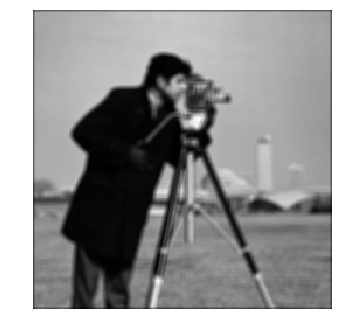

In [5]:
# 2D filtering
mean_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
filt_im, time_naive = naive_conv(im, mean_kernel)

print("Elapsed: ", time_naive)
plt.imshow(filt_im, cmap='gray')
plt.axis('off')

To be sure, let us compare it with the scipy implementation

In [6]:
scipy_filtered = signal.convolve2d(im, mean_kernel, mode='same', boundary='fill')
print(np.max(np.abs(scipy_filtered - filt_im)))

0.0


Great, now, let us implement a function tha computes the same 2d convolution, but now we use the separability of the filters to speed up things. This implementation should have a complexity of about

$$
    \mathcal{O}(M N L).
$$

In terms of floating point operations (flops), it should have about

$$
    M\cdot N\cdot 2L
$$

multiplications and

$$
    M N (2(L - 1))
$$

additions, in total

$$
    flops_{sep} \approx MN(4L - 2).
$$

Here the image has *M* rows and *N* columns, and each kernel has *L* as side length.

In [7]:
def naive_conv_separable(image, kernel_1, kernel_2):
    """
    A brute force implementation of 2D convolution with zero padding, using a separable filter.
    
    Args:
        image: 2D numpy array
        kernel_1: 1D numpy array, odd side lengths
        kernel_2: 1D numpy array, odd side lengths
    Returns:
        filtered_image_2: 2D numpy array of float64, equal size to image
        end_time: Elapsed time in seconds of convolution loop
    """
    M, N = image.shape
    S = int((kernel_1.shape[0] - 1)/2)
    T = int((kernel_2.shape[0] - 1)/2)
    padded_image = np.lib.pad(image, ((S, S), (0, 0)), 'constant', constant_values=((0, 0), (0, 0))).astype('float64')
    filtered_image_1 = np.zeros((image.shape[0], image.shape[1] + 2*T))
    filtered_image_2 = np.zeros(image.shape)
    start_time = time.time()
    # Vertical 1D filter
    for i in range(M):
        for j in range(N):
            for s in range(2*S + 1):
                filtered_image_1[i, j+T] += padded_image[i-s + 2*S, j]*kernel_1[s]
    # Horizontal 1D filter
    for i in range(M):
        for j in range(N):
            for t in range(2*T + 1):
                filtered_image_2[i, j] += filtered_image_1[i, j - t + 2*T]*kernel_2[t]
    end_time = time.time() - start_time
    return filtered_image_2, end_time

Try to run it, and display the result.

Elapsed:  0.48999762535095215


(-0.5, 255.5, 255.5, -0.5)

/home/oskrede/anaconda3/envs/inf2310/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


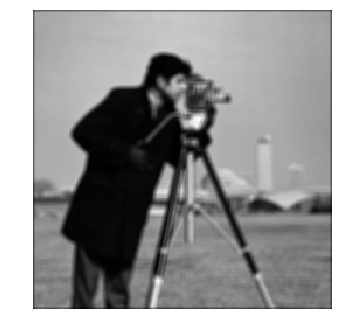

In [8]:
# 2 times 1D separable filtering
mean_kernel_1 = np.ones((kernel_size)) / kernel_size
mean_kernel_2 = np.ones((kernel_size)) / kernel_size
filt_im_sep, time_naive_sep = naive_conv_separable(im, mean_kernel_1, mean_kernel_2)

print("Elapsed: ", time_naive_sep)
plt.imshow(filt_im_sep, cmap='gray')
plt.axis('off')

Check this one, just to be sure

In [9]:
print(np.max(np.abs(scipy_filtered - filt_im_sep)))

1.70530256582e-13


For our purpose, this is as good as equal (just some numerical noise hindering equivalence).

# Varying kernel size

Now, from our small complexity analysis, we should expect that the computation cost by not utilizing filter separability of the filters to scale as

$$
    \delta := \frac{flops_{nonsep}}{flops_{sep}} = \frac{2L^2 - 1}{4L - 2}
$$

or asymptotically

$$
    \delta_{approx} := \frac{L}{2} + \frac{1}{4}
$$

Let us put compare these costs with the computed run time of our convolution functions.

In [10]:
def delta(kernel_sizes):
    """Compute theoretical computation cost w.r.t. kernel size
    
    Args:
        kernel_sizes: Array-like object of kernel sizes
    Returns:
        delta: Array-like object of same length as kernel_sizes.
        delta_approx: Approximation of delta
    """
    delta = [(2*k*k - 1)/(4*k - 2) for k in kernel_sizes]
    delta_approx = [(2*k + 1)/4 for k in kernel_sizes]
    
    return delta, delta_approx

Let us test our implementation for the following kernel size values

In [11]:
L = [3, 5, 7, 9, 11, 13, 15]

In order to increase the accuracy, we can do the computation a couple of times, and take the mean time for each. Notice that this will take some time.

In [12]:
num_runs = 1
tot_time_nonsep = np.zeros(len(L))
tot_time_sep = np.zeros(len(L))
for i, l in enumerate(L):
    test_time_nonsep = np.zeros(num_runs)
    test_time_sep = np.zeros(num_runs)
    mean_kernel_2d = np.ones((l, l)) / (l*l)
    mean_kernel_1d = np.ones((l)) / l
    for run in range(num_runs):
        _, test_time_nonsep[run] = naive_conv(im, mean_kernel_2d)
        _, test_time_sep[run] = naive_conv_separable(im, mean_kernel_1d, mean_kernel_1d)
    tot_time_nonsep[i] = np.mean(test_time_nonsep)
    tot_time_sep[i] = np.mean(test_time_sep)
        

Plot the results, first the timings

/home/oskrede/anaconda3/envs/inf2310/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


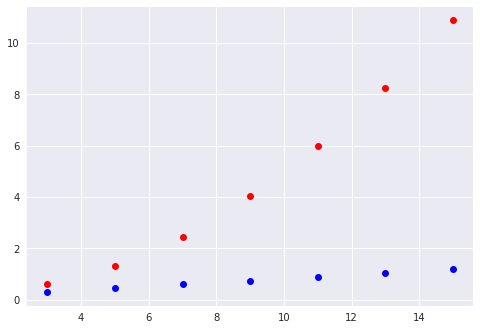

In [13]:
plt.plot(L, tot_time_nonsep, 'ro')
plt.plot(L, tot_time_sep, 'bo')

Then, let us plot the cost versus the theoretical

In [14]:
x = np.linspace(3, 15)
d, d_approx = delta(x)

fig = plt.figure()
plt.plot(x, d, 'g')
plt.plot(x, d_approx, 'b')
plt.plot(L, tot_time_nonsep/tot_time_sep, 'ro')

import mpld3 # Enables interactive matplotlib in notebook. [conda install mpld3]
mpld3.display(fig)

/home/oskrede/anaconda3/envs/inf2310/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


As we can see, the trend is about linear in kernel side length, as expected.